# Predicting House Prices Using Machine Learning and Feature Engineering

**What is The Business Problem to solve ? **

Housing prices vary due to many factors like location, size, number of rooms, and more. The goal of this project is to build a machine learning model that accurately predicts house prices based on various features in a structured dataset. This can help real estate professionals make better decisions.help them in investment planning and risk mitigation.

In [1]:
import ray
ray.init()

2025-06-24 10:25:23,480	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-24 10:25:30,544	INFO worker.py:1908 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.12.3
Ray version:,2.47.1
Dashboard:,http://127.0.0.1:8265


In [10]:
!pip show pyarrow
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 1.5 MB/s eta 0:00:0000:0100:01


In [11]:
import sys
print(sys.executable)

/home/hiba/Desktop/scalable-house-price-prediction/.venv/bin/python


In [17]:
import ray
ds = ray.data.read_csv("properties_data.csv")
db = ds.to_pandas()
# Display the first few rows of the DataFrame
print(db.head())

2025-06-24 15:07:21,360	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-24 15:07:22,303	INFO logging.py:295 -- Registered dataset logger for dataset dataset_0_0
2025-06-24 15:07:22,336	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_0_0. Full logs are in /tmp/ray/session_2025-06-24_14-47-39_482051_456528/logs/ray-data
2025-06-24 15:07:22,337	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_0_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV]
Running 0: 0.00 row [00:00, ? row/s]2025-06-24 15:07:23,283	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_0_0 execution finished in 0.95 seconds
                                                                                                                   
✔️  Dataset dataset_0_0 execution finished in 0.95 seconds: 100%|██████████| 1.91k/1.91k [00:00<00:00, 1.97k row/s]

- ReadCSV->S

        id          neighborhood   latitude  longitude    price  size_in_sqft  \
0  5528049         Palm Jumeirah  25.113208  55.138932  2700000          1079   
1  6008529         Palm Jumeirah  25.106809  55.151201  2850000          1582   
2  6034542  Jumeirah Lake Towers  25.063302  55.137728  1150000          1951   
3  6326063       Culture Village  25.227295  55.341761  2850000          2020   
4  6356778         Palm Jumeirah  25.114275  55.139764  1729200           507   

   price_per_sqft  no_of_bedrooms  no_of_bathrooms quality  ...  private_pool  \
0         2502.32               1                2  Medium  ...         False   
1         1801.52               2                2  Medium  ...         False   
2          589.44               3                5  Medium  ...         False   
3         1410.89               2                3     Low  ...         False   
4         3410.65               0                1  Medium  ...         False   

   security  shared_gym  s

In [18]:
import ray
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.gridspec import GridSpec
#from matplotlib import style

In [ ]:
db.columns

Index(['id', 'neighborhood', 'latitude', 'longitude', 'price', 'size_in_sqft',
       'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms', 'quality',
       'maid_room', 'unfurnished', 'balcony', 'barbecue_area',
       'built_in_wardrobes', 'central_ac', 'childrens_play_area',
       'childrens_pool', 'concierge', 'covered_parking', 'kitchen_appliances',
       'lobby_in_building', 'maid_service', 'networked', 'pets_allowed',
       'private_garden', 'private_gym', 'private_jacuzzi', 'private_pool',
       'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study',
       'vastu_compliant', 'view_of_landmark', 'view_of_water',
       'walk_in_closet'],
      dtype='object')

In [ ]:
#setting the max columns to be displayed, because pandas by default doesn't show all the columns in the dataframe
#so using this methode is better for exploration , shows all columns
pd.set_option('display.max_columns', 200)
db

,id,neighborhood,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,maid_room,unfurnished,balcony,barbecue_area,built_in_wardrobes,central_ac,childrens_play_area,childrens_pool,concierge,covered_parking,kitchen_appliances,lobby_in_building,maid_service,networked,pets_allowed,private_garden,private_gym,private_jacuzzi,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet
0,5528049,Palm Jumeirah,25.113208,55.138932,2700000,1079,2502.32,1,2,Medium,False,False,True,True,False,True,True,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False
1,6008529,Palm Jumeirah,25.106809,55.151201,2850000,1582,1801.52,2,2,Medium,False,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False
2,6034542,Jumeirah Lake Towers,25.063302,55.137728,1150000,1951,589.44,3,5,Medium,True,True,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,True,True,True,False,False,False,True,True,True
3,6326063,Culture Village,25.227295,55.341761,2850000,2020,1410.89,2,3,Low,False,True,True,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4,6356778,Palm Jumeirah,25.114275,55.139764,1729200,507,3410.65,0,1,Medium,False,False,False,False,True,True,False,False,False,True,True,False,False,True,False,False,False,False,False,True,True,True,True,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,7705450,Mohammed Bin Rashid City,25.176892,55.310712,1500000,1087,1379.94,2,2,Ultra,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,True,True,True,True,True,True,True,True,True
1901,7706287,Mohammed Bin Rashid City,25.166145,55.276684,1230000,760,1618.42,1,2,Medium,False,False,True,False,True,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True
1902,7706389,Dubai Creek Harbour (The Lagoons),25.206500,55.345056,2900000,1930,1502.59,3,5,Medium,True,True,True,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False
1903,7706591,Jumeirah Village Circle,25.073858,55.229844,675000,740,912.16,1,2,Medium,False,True,True,False,True,True,True,False,False,True,True,False,False,False,False,True,False,False,False,True,True,True,False,False,False,False,True,True


In [ ]:
db.info()
db.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905 entries, 0 to 1904
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1905 non-null   int64  
 1   neighborhood         1905 non-null   object 
 2   latitude             1905 non-null   float64
 3   longitude            1905 non-null   float64
 4   price                1905 non-null   int64  
 5   size_in_sqft         1905 non-null   int64  
 6   price_per_sqft       1905 non-null   float64
 7   no_of_bedrooms       1905 non-null   int64  
 8   no_of_bathrooms      1905 non-null   int64  
 9   quality              1905 non-null   object 
 10  maid_room            1905 non-null   bool   
 11  unfurnished          1905 non-null   bool   
 12  balcony              1905 non-null   bool   
 13  barbecue_area        1905 non-null   bool   
 14  built_in_wardrobes   1905 non-null   bool   
 15  central_ac           1905 non-null   b

,id,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms
count,1.905000e+03,1905.000000,1905.000000,1.905000e+03,1905.000000,1905.000000,1905.000000,1905.000000
mean,7.573308e+06,25.116538,55.212338,2.085830e+06,1417.050394,1327.243785,1.793176,2.512861
std,1.925252e+05,0.062647,0.068794,2.913200e+06,891.487639,668.473559,0.949489,1.063117
min,5.528049e+06,24.865992,55.069311,2.200000e+05,294.000000,361.870000,0.000000,1.000000
25%,7.560167e+06,25.072791,55.145389,8.900000e+05,840.000000,870.920000,1.000000,2.000000
50%,7.631829e+06,25.096700,55.207506,1.400000e+06,1271.000000,1169.590000,2.000000,2.000000
75%,7.670328e+06,25.188130,55.271797,2.200000e+06,1703.000000,1622.500000,2.000000,3.000000
max,7.706643e+06,25.273623,55.441623,3.500000e+07,9576.000000,4805.870000,5.000000,6.000000


In [ ]:
db.dtypes

,0
id,int64
neighborhood,object
latitude,float64
longitude,float64
price,int64
size_in_sqft,int64
price_per_sqft,float64
no_of_bedrooms,int64
no_of_bathrooms,int64
quality,object


In [ ]:
db .shape[0]

1905

In [ ]:
db.columns

Index(['id', 'neighborhood', 'latitude', 'longitude', 'price', 'size_in_sqft',
       'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms', 'quality',
       'maid_room', 'unfurnished', 'balcony', 'barbecue_area',
       'built_in_wardrobes', 'central_ac', 'childrens_play_area',
       'childrens_pool', 'concierge', 'covered_parking', 'kitchen_appliances',
       'lobby_in_building', 'maid_service', 'networked', 'pets_allowed',
       'private_garden', 'private_gym', 'private_jacuzzi', 'private_pool',
       'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study',
       'vastu_compliant', 'view_of_landmark', 'view_of_water',
       'walk_in_closet'],
      dtype='object')

In [ ]:
for col in db.columns:
    missing = np.mean(db[col].isnull())
    print('{} - {}%'.format(col, missing))

id - 0.0%
neighborhood - 0.0%
latitude - 0.0%
longitude - 0.0%
price - 0.0%
size_in_sqft - 0.0%
price_per_sqft - 0.0%
no_of_bedrooms - 0.0%
no_of_bathrooms - 0.0%
quality - 0.0%
unfurnished - 0.0%
balcony - 0.0%
barbecue_area - 0.0%
built_in_wardrobes - 0.0%
central_ac - 0.0%
concierge - 0.0%
kitchen_appliances - 0.0%
lobby_in_building - 0.0%
maid_service - 0.0%
networked - 0.0%
private_garden - 0.0%
private_gym - 0.0%
private_jacuzzi - 0.0%
private_pool - 0.0%
security - 0.0%
vastu_compliant - 0.0%
view_of_landmark - 0.0%
view_of_water - 0.0%


In [ ]:
db.isna().sum()

,0
id,0
neighborhood,0
latitude,0
longitude,0
price,0
size_in_sqft,0
price_per_sqft,0
no_of_bedrooms,0
no_of_bathrooms,0
quality,0


In [ ]:
#shows us the rows the second time they are duplicated
db.loc[db.duplicated(subset=['id'])]

,id,neighborhood,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,...,maid_service,networked,private_garden,private_gym,private_jacuzzi,private_pool,security,vastu_compliant,view_of_landmark,view_of_water


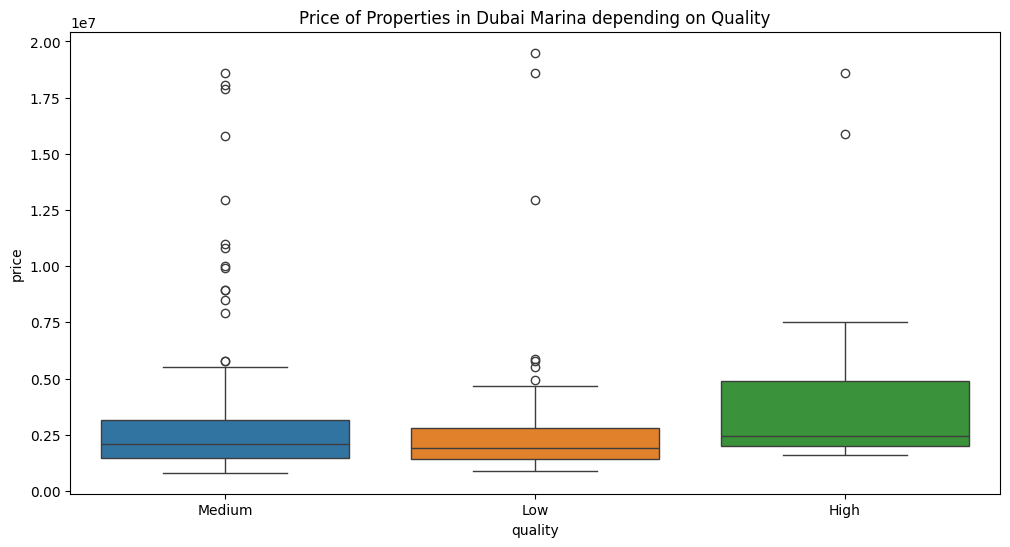

In [ ]:
#price of properties depending on the quality in one single location
specific_loc = "Downtown Dubai"
vis_specific_loc = db[db['neighborhood'] == specific_loc]
vis_specific_loc = vis_specific_loc.sort_values(by="price")
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x="quality", y="price", data=vis_specific_loc, ax=ax, hue='quality')
plt.xlabel("quality")
plt.ylabel("price")
plt.title("Price of Properties in Dubai Marina depending on Quality")
plt.show()

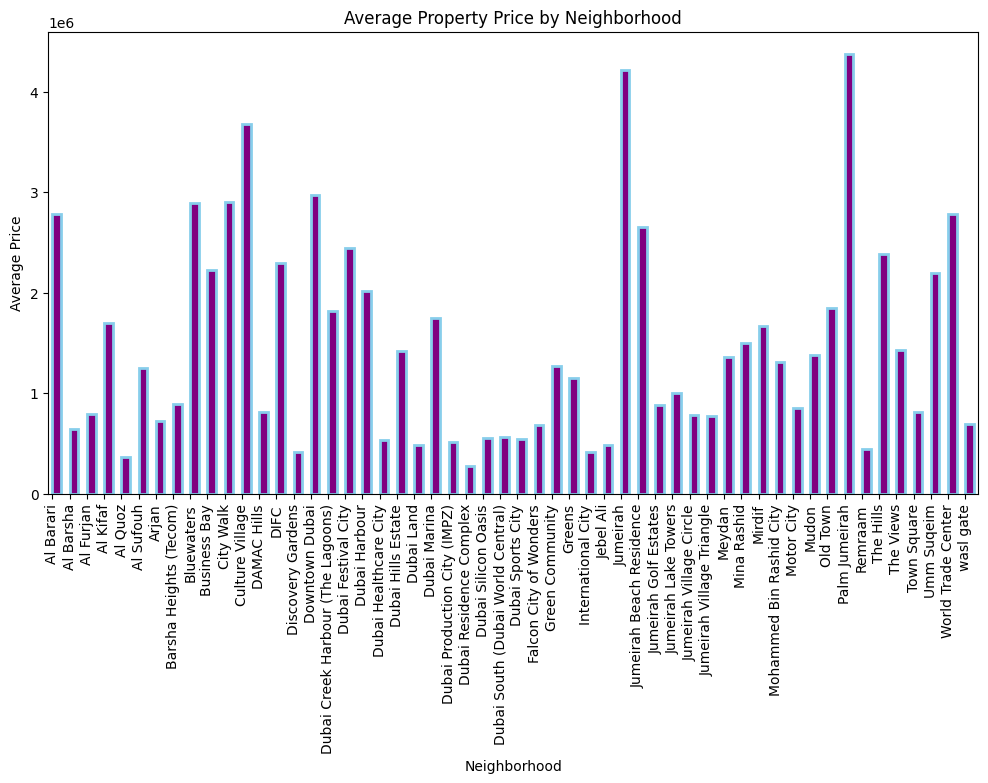

In [ ]:
#calculating the average price for each neighborhood
price_by_neighborhood = db.groupby('neighborhood')['price'].mean()
ax = price_by_neighborhood.plot(kind='bar', figsize=(12, 6), color='purple', align="edge", edgecolor="skyblue", lw=2)
plt.xlabel("Neighborhood")
plt.ylabel("Average Price")
plt.title("Average Property Price by Neighborhood")
#plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

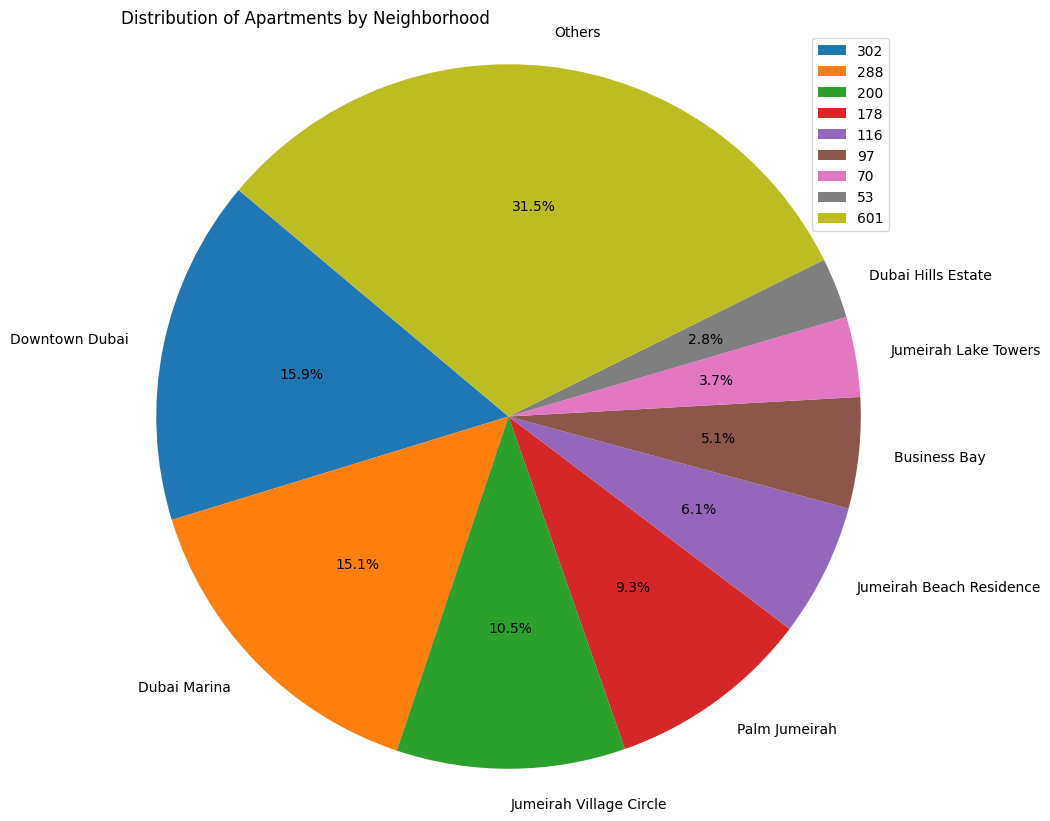

In [ ]:
#where most of the properties are located
#since we have so many neighborhood we can group them
neighb_count = db['neighborhood'].value_counts()
grouped_neighb = neighb_count[neighb_count <  50].sum()
N_neighb_count = neighb_count[neighb_count >= 50]
N_neighb_count['Others'] = grouped_neighb
plt.figure(figsize=(10, 10))
plt.pie(N_neighb_count, labels=N_neighb_count.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Apartments by Neighborhood", loc='left')
plt.legend(labels=N_neighb_count, loc='upper right')
plt.axis('equal')
#style.use("white_background")
plt.show()

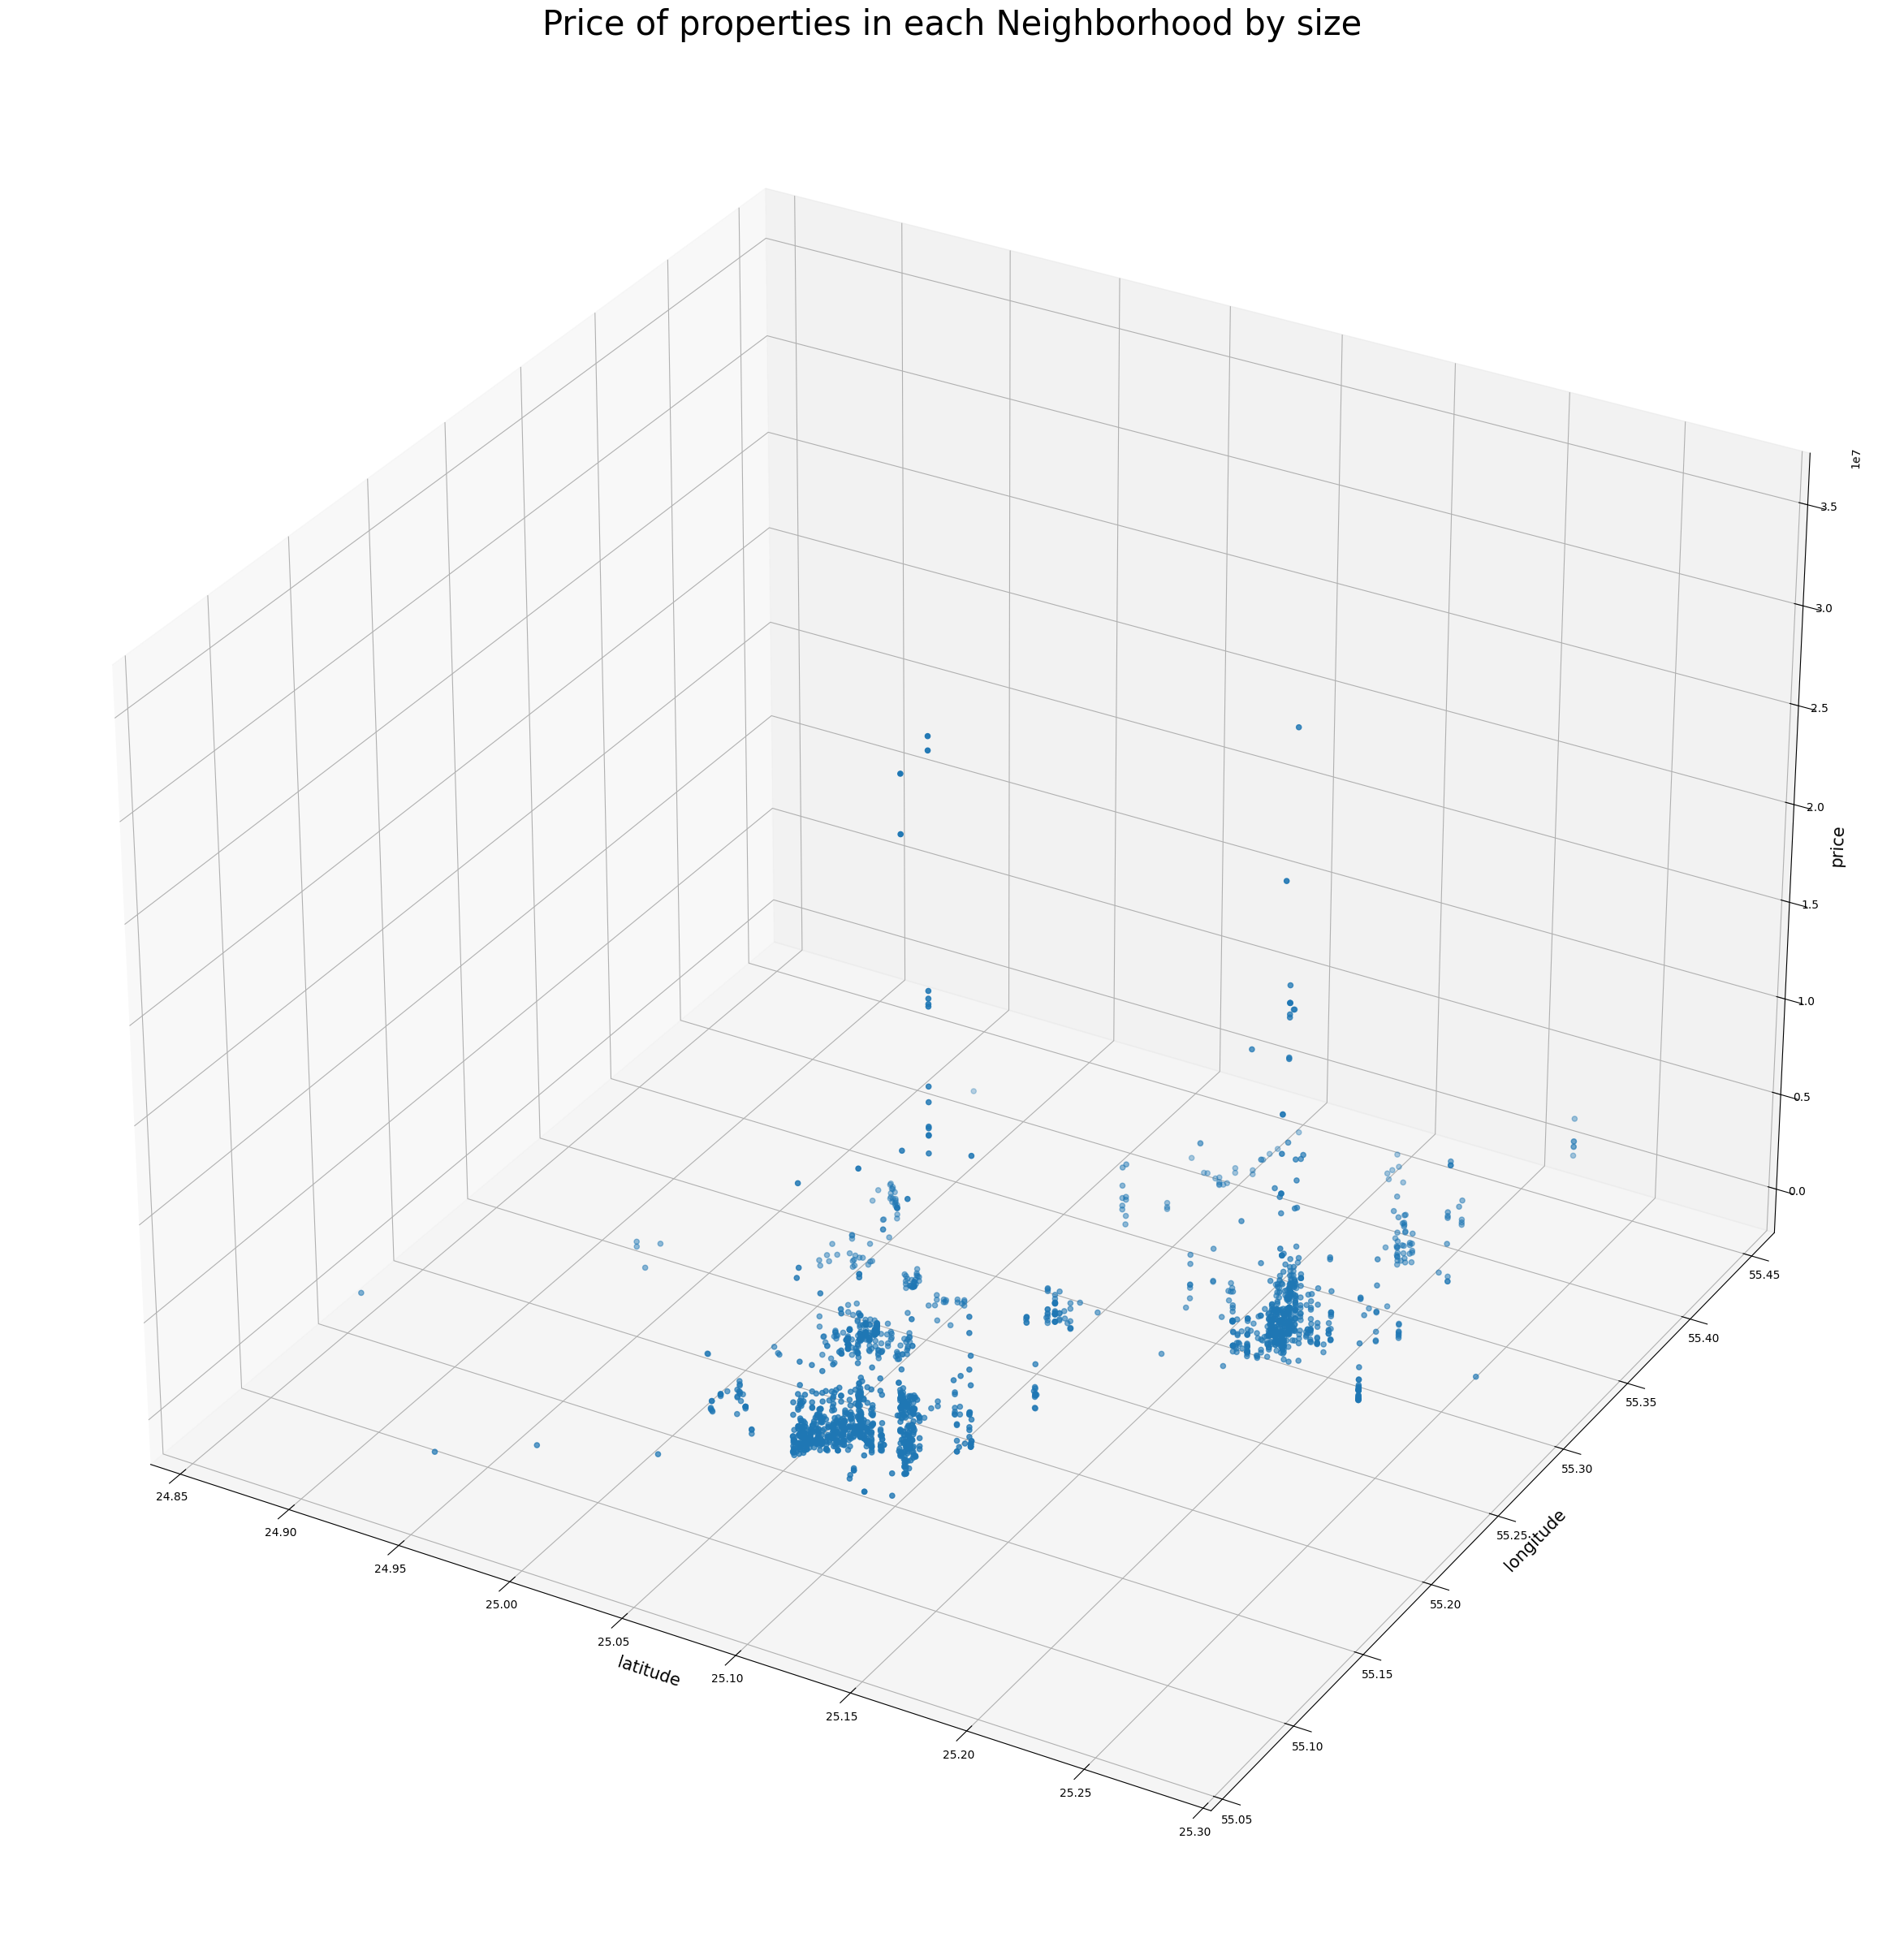

In [ ]:
#creating plots to visualize
#price depending on the size using scatter plot
#it shows that large properties cost more
from mpl_toolkits.mplot3d import Axes3D
db = db.sort_values(by="price")
fig, ax = plt.subplots(figsize=(30, 60), subplot_kw={'projection': '3d'})
#ax = plt.axes(projection="3D")
ax.scatter(db["latitude"], db["longitude"], db["price"])
ax.set_xlabel("latitude", fontsize=15) # Changed plt.xlabel to ax.set_xlabel
ax.set_ylabel("longitude", fontsize=15) # Changed plt.ylabel to ax.set_ylabel
ax.set_zlabel("price", fontsize=15)
plt.title("Price of properties in each Neighborhood by size", fontsize=30)
plt.show()

In [5]:
#finding the correlation between the features of the datatset
db_corr =db[['price',	'latitude','longitude','size_in_sqft',
            'price_per_sqft',	'no_of_bedrooms',	'no_of_bathrooms']].corr()
db_corr

,price,latitude,longitude,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms
price,1.000000,0.206775,-0.015395,0.808595,0.705538,0.514151,0.502263
latitude,0.206775,1.000000,0.605875,0.137518,0.409887,0.124162,0.141160
longitude,-0.015395,0.605875,1.000000,-0.066657,0.020590,-0.045668,-0.025000
size_in_sqft,0.808595,0.137518,-0.066657,1.000000,0.344276,0.775113,0.725397
price_per_sqft,0.705538,0.409887,0.020590,0.344276,1.000000,0.226340,0.236630
no_of_bedrooms,0.514151,0.124162,-0.045668,0.775113,0.226340,1.000000,0.854384
no_of_bathrooms,0.502263,0.141160,-0.025000,0.725397,0.236630,0.854384,1.000000


In [ ]:
num_cols=db[['price',	'latitude','longitude','size_in_sqft',
            'price_per_sqft',	'no_of_bedrooms',	'no_of_bathrooms']]
sns.pairplot(num_cols)

<Axes: >

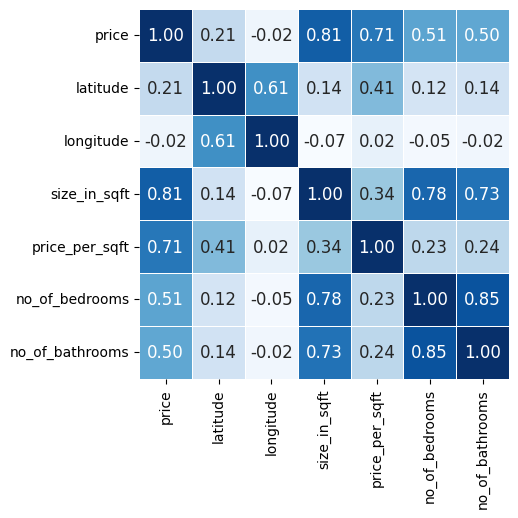

In [ ]:
sns.heatmap(db_corr, annot=True, cmap='Blues', linewidths=0.5, fmt='.2f', annot_kws={"size": 12}, cbar=False, square=True)

In [53]:
#answering the question where the most properties are located , and what does price have to do with that
neighborhood_sum = db.groupby('neighborhood').agg(
    property_count=('neighborhood', 'size'),
    average_price=('price', 'mean')
).reset_index()
neighborhood_sum = neighborhood_sum.sort_values(by='average_price', ascending=True)

neighborhood_sum


,neighborhood,property_count,average_price
24,Dubai Residence Complex,1,2.700000e+05
4,Al Quoz,1,3.600000e+05
14,Discovery Gardens,8,4.142500e+05
31,International City,6,4.160000e+05
47,Remraam,6,4.443330e+05
32,Jebel Ali,2,4.850000e+05
21,Dubai Land,11,4.854545e+05
23,Dubai Production City (IMPZ),8,5.125000e+05
19,Dubai Healthcare City,2,5.290000e+05
27,Dubai Sports City,25,5.428000e+05


2025-06-24 15:08:55,670	INFO logging.py:295 -- Registered dataset logger for dataset dataset_1_0
2025-06-24 15:08:55,682	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_1_0. Full logs are in /tmp/ray/session_2025-06-24_14-47-39_482051_456528/logs/ray-data
2025-06-24 15:08:55,683	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_1_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(remove_outliers)]
Running 0: 0.00 row [00:00, ? row/s]


Running Dataset: dataset_1_0. Active & requested resources: 1/8 CPU, 256.2MB/548.6MB object store: : 0.00 row [00:01, ? row/s]



Running Dataset: dataset_1_0. Active & requested resources: 2/8 CPU, 69.0KB/548.6MB object store:  88%|████████▊ | 1.54k/1.76k [00:03<00:00, 491 row/s]



2025-06-24 15:08:59,034	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_1_0 execution finished in 3.35 seconds
                                                                           

<Axes: >

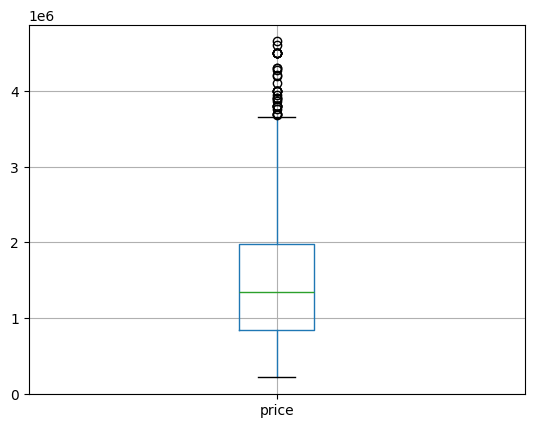

In [19]:
#removing outliers from price using IQR
# Q1 = db['price'].quantile(0.25)
# Q3 = db['price'].quantile(0.75)
# IQR = Q3 - Q1
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# db = db[(db['price'] >= lower_bound) & (db['price'] <= upper_bound)]
def remove_outliers(df):
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df['price'] >= lower) & (df['price'] <= upper)]

ds = ds.map_batches(remove_outliers, batch_format="pandas")
db = ds.to_pandas()
db.boxplot(column=['price'])

**K-means clustering **: is an unsupervised learning algorithm used for data clustering, which groups unlabeled data points into groups or clusters.

#Feature Engineering

Feature Engineering is the process of creating new features or transforming existing features to improve the performance of a machine-learning model. It involves selecting relevant information from raw data and transforming it into a format that can be easily understood by a model.

# 1. Feature Transformation

In [20]:
numerical_cols = db.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = db.select_dtypes(include=["object"]).columns

In [21]:
#Label encoding for categorical features
import pandas as pd
def label_encode(df: pd.DataFrame) -> pd.DataFrame:
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == "object" or df[col].dtype.name == "bool":
            df[col] = label_encoder.fit_transform(df[col].astype(str))
    return df
ds = ds.map_batches(label_encode, batch_format="pandas")
db = ds.to_pandas()
db.head()

2025-06-24 15:09:31,616	INFO logging.py:295 -- Registered dataset logger for dataset dataset_2_0
2025-06-24 15:09:31,626	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_2_0. Full logs are in /tmp/ray/session_2025-06-24_14-47-39_482051_456528/logs/ray-data
2025-06-24 15:09:31,626	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_2_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(remove_outliers)->MapBatches(label_encode)]
Running 0: 0.00 row [00:00, ? row/s]




Running Dataset: dataset_2_0. Active & requested resources: 4/8 CPU, 179.8KB/548.6MB object store:  75%|███████▌  | 1.33k/1.78k [00:02<00:00, 670 row/s]



2025-06-24 15:09:34,428	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_2_0 execution finished in 2.80 seconds
                                                                                                                                                        
                       

,id,neighborhood,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,...,private_pool,security,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet
0,5528049,23,25.113208,55.138932,2700000,1079,2502.32,1,2,2,...,0,0,1,0,0,0,0,0,1,0
1,6008529,23,25.106809,55.151201,2850000,1582,1801.52,2,2,2,...,0,0,1,1,0,0,0,0,1,0
2,6034542,18,25.063302,55.137728,1150000,1951,589.44,3,5,2,...,0,1,1,1,0,0,0,1,1,1
3,6326063,7,25.227295,55.341761,2850000,2020,1410.89,2,3,1,...,0,0,0,0,0,0,0,0,0,0
4,6356778,23,25.114275,55.139764,1729200,507,3410.65,0,1,2,...,0,1,1,1,1,0,0,1,1,0


# 2. Feature Creation

the process of generating new features based on domain knowledge or by observing patterns in the data

In [22]:

def create_bedrooms_bathrooms_feature(df):
    df['bedrooms_bathrooms'] = df['no_of_bedrooms'] * df['no_of_bathrooms']
    return df

ds = ds.map_batches(create_bedrooms_bathrooms_feature, batch_format="pandas")
db = ds.to_pandas()
db.columns

2025-06-24 15:09:39,225	INFO logging.py:295 -- Registered dataset logger for dataset dataset_3_0
2025-06-24 15:09:39,264	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_3_0. Full logs are in /tmp/ray/session_2025-06-24_14-47-39_482051_456528/logs/ray-data
2025-06-24 15:09:39,267	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_3_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(remove_outliers)->MapBatches(label_encode)->MapBatches(create_bedrooms_bathrooms_feature)]
Running 0: 0.00 row [00:00, ? row/s]2025-06-24 15:09:39,295	WARNING progress_bar.py:120 -- Truncating long operator name to 100 characters. To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.

2025-06-24 15:09:40,058	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_3_0 execution finished in 0.79 seconds
                                                                 

Index(['id', 'neighborhood', 'latitude', 'longitude', 'price', 'size_in_sqft',
       'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms', 'quality',
       'maid_room', 'unfurnished', 'balcony', 'barbecue_area',
       'built_in_wardrobes', 'central_ac', 'childrens_play_area',
       'childrens_pool', 'concierge', 'covered_parking', 'kitchen_appliances',
       'lobby_in_building', 'maid_service', 'networked', 'pets_allowed',
       'private_garden', 'private_gym', 'private_jacuzzi', 'private_pool',
       'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study',
       'vastu_compliant', 'view_of_landmark', 'view_of_water',
       'walk_in_closet', 'bedrooms_bathrooms'],
      dtype='object')

**Target Encoding** : (Mean Encoding): This method encodes each category with the mean of the target variable ('price') for that category.

How it works: For each neighborhood, I calculated the average price of properties in that neighborhood and replace the neighborhood name with that average price.
Advantages: It can capture the relationship between the category and the target variable directly and doesn't increase the number of features as much as one-hot encoding.

In [23]:
#Calculate the mean price for each neighborhood
def target_encode_neighborhood(df):
    neighborhood_prices = df.groupby('neighborhood')['price'].mean()
    df['neighborhood_target_encoded'] = df['neighborhood'].map(neighborhood_prices)
    return df
ds = ds.map_batches(target_encode_neighborhood, batch_format="pandas")
db = ds.to_pandas()
db.columns

2025-06-24 15:09:46,263	INFO logging.py:295 -- Registered dataset logger for dataset dataset_4_0
2025-06-24 15:09:46,283	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_4_0. Full logs are in /tmp/ray/session_2025-06-24_14-47-39_482051_456528/logs/ray-data
2025-06-24 15:09:46,284	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_4_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(remove_outliers)->MapBatches(label_encode)->MapBatches(create_bedrooms_bathrooms_feature)->MapBatches(target_encode_neighborhood)]
Running 0: 0.00 row [00:00, ? row/s]
2025-06-24 15:09:46,970	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_4_0 execution finished in 0.69 seconds
                                                                                                                   
                                                    

✔️  Dataset dataset_4_0 execution finished in 0.69 seconds: 100%|██████████| 1.

Index(['id', 'neighborhood', 'latitude', 'longitude', 'price', 'size_in_sqft',
       'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms', 'quality',
       'maid_room', 'unfurnished', 'balcony', 'barbecue_area',
       'built_in_wardrobes', 'central_ac', 'childrens_play_area',
       'childrens_pool', 'concierge', 'covered_parking', 'kitchen_appliances',
       'lobby_in_building', 'maid_service', 'networked', 'pets_allowed',
       'private_garden', 'private_gym', 'private_jacuzzi', 'private_pool',
       'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study',
       'vastu_compliant', 'view_of_landmark', 'view_of_water',
       'walk_in_closet', 'bedrooms_bathrooms', 'neighborhood_target_encoded'],
      dtype='object')

In [24]:
#using IQR
import numpy as np
def remove_outliers_iqr(df):
    cleaned_df = df.copy()
    numeric_cols = cleaned_df.select_dtypes(include=np.number).columns
    for column in numeric_cols:
      if pd.api.types.is_numeric_dtype(cleaned_df[column]):
        Q1 = cleaned_df[column].quantile(0.25)
        Q3 = cleaned_df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Replace outliers with NaN
        cleaned_df[column] = cleaned_df[column].where(
            (cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound)
        )
  #drop rows with any NaNs caused by outliers
    cleaned_df = cleaned_df.dropna()
    return cleaned_df

# Select only the numerical columns except 'id'
X_selected_df = db[numerical_cols].drop('id', axis=1).copy()
cleaned_features = remove_outliers_iqr(X_selected_df)
print("Original shape:", X_selected_df.shape)
print("After removing outliers:", cleaned_features.shape)


Original shape: (1763, 7)
After removing outliers: (1645, 7)


In [11]:
db.head()

,id,neighborhood,latitude,longitude,price,size_in_sqft,price_per_sqft,no_of_bedrooms,no_of_bathrooms,quality,...,shared_gym,shared_pool,shared_spa,study,vastu_compliant,view_of_landmark,view_of_water,walk_in_closet,bedrooms_bathrooms,neighborhood_target_encoded
0,5528049,23,25.113208,55.138932,2700000,1079,2502.32,1,2,2,...,1,0,0,0,0,0,1,0,2,2.433142e+06
1,6008529,23,25.106809,55.151201,2850000,1582,1801.52,2,2,2,...,1,1,0,0,0,0,1,0,4,2.433142e+06
2,6034542,18,25.063302,55.137728,1150000,1951,589.44,3,5,2,...,1,1,0,0,0,1,1,1,15,7.950000e+05
3,6326063,7,25.227295,55.341761,2850000,2020,1410.89,2,3,1,...,0,0,0,0,0,0,0,0,6,3.675000e+06
4,6356778,23,25.114275,55.139764,1729200,507,3410.65,0,1,2,...,1,1,1,0,0,1,1,0,0,2.433142e+06


#featue selection for model training
Feature selection is the process of selecting a subset of relevant features for use in model construction, In fact, too many features usually mean worse performance and slower training, because extra features add noise. Every irrelevant feature makes your model a little bit worse at finding the real patterns.The primary benefits of feature selection include:



* Reducing Overfitting: By removing irrelevant or redundant features, the model is less likely to learn from noise.
* Improving Accuracy: Focusing on the most important features can improve the predictive performance of the model.

* Reducing Training Time: Fewer features mean faster training times.

#feature scaling
transforming the features so that they have a similar scale

**Types of Feature Scaling:**

1. Min-Max Scaling: Rescaling the features to a specific range, such as between 0 and 1, by subtracting the minimum value and dividing by the range.
2. Standard Scaling: Rescaling the features to have a mean of 0 and a standard deviation of 1 by subtracting the mean and dividing by the standard deviation.
3.Robust Scaling: Rescaling the features to be robust to outliers by dividing them by the interquartile range.

**Why Feature Scaling?**

Improves Model Performance: By transforming the features to have a similar scale, the model can learn from all features equally and avoid being dominated by a few large features.

In [58]:
def scale_numerical_columns(df: pd.DataFrame) -> pd.DataFrame:
    from sklearn.preprocessing import StandardScaler

    numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df
ds = ds.map_batches(scale_numerical_columns, batch_format="pandas")
db = ds.to_pandas()

2025-06-24 15:21:51,129	INFO logging.py:295 -- Registered dataset logger for dataset dataset_7_0
2025-06-24 15:21:51,147	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_7_0. Full logs are in /tmp/ray/session_2025-06-24_14-47-39_482051_456528/logs/ray-data
2025-06-24 15:21:51,148	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_7_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadCSV] -> TaskPoolMapOperator[MapBatches(remove_outliers)->MapBatches(label_encode)->MapBatches(create_bedrooms_bathrooms_feature)->MapBatches(target_encode_neighborhood)->MapBatches(scale_numerical_columns)->MapBatches(scale_numerical_columns)->MapBatches(scale_numerical_columns)]
Running 0: 0.00 row [00:00, ? row/s]
2025-06-24 15:21:52,010	INFO streaming_executor.py:227 -- ✔️  Dataset dataset_7_0 execution finished in 0.86 seconds
                                                                                                                   
                      

In [59]:
#feature selection to reduce the number of features for the model, which can help to improve accuracy and model performance , using selectKbest
X = db.drop(columns=['id', 'neighborhood', 'price', 'no_of_bedrooms', 'no_of_bathrooms'])
y = db['price']
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func=f_regression, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['latitude', 'size_in_sqft', 'price_per_sqft', 'maid_room',
       'barbecue_area', 'pets_allowed', 'security', 'view_of_water',
       'bedrooms_bathrooms', 'neighborhood_target_encoded'],
      dtype='object')


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [ ]:
pip install ray[tune] xgboost

In [62]:
#linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("RMSE (LinearRegression - OLS):", rmse_lr)

RMSE (LinearRegression - OLS): 0.2764439810388593


In [ ]:
pip install ray[tune] scikit-learn

In [37]:
import ray
from ray import tune
from ray import train
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
import numpy as np

#split the data into training and testing sets

def train_rf(config, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        min_samples_split=config["min_samples_split"],
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    train.report({"rmse": rmse})
search_space = {
    "n_estimators": tune.choice([50, 100, 150]),
    "max_depth": tune.randint(5, 20),
    "min_samples_split": tune.randint(2, 10)
}

tuner = tune.Tuner(
    tune.with_parameters(
        train_rf,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    ),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="rmse",
        mode="min",
    ),
)

results = tuner.fit()
best_result = results.get_best_result(metric="rmse", mode="min")
print("Best RMSE:", best_result.metrics["rmse"])

2025-06-24 15:15:52,279	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/hiba/ray_results/train_rf_2025-06-24_15-15-47' in 0.0034s.
2025-06-24 15:15:52,283	INFO tune.py:1041 -- Total run time: 4.37 seconds (4.34 seconds for the tuning loop).


Best RMSE: 0.16214731542940497


In [38]:
# Retrain RandomForestRegressor with best hyperparameters from Ray Tune
from sklearn.ensemble import RandomForestRegressor
best_rf_config = best_result.config
rf_model = RandomForestRegressor(
    n_estimators=best_rf_config.get("n_estimators", 100),
    max_depth=best_rf_config.get("max_depth", None),
    min_samples_split=best_rf_config.get("min_samples_split", 2),
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

In [39]:
from ray import train
from sklearn.metrics import mean_squared_error
import numpy as np
from xgboost import XGBRegressor
def train_xgb(config, X_train, X_test, y_train, y_test):
    model = XGBRegressor(
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        learning_rate=config["learning_rate"],
        eval_metric="rmse",
        random_state=42
    )
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    train.report({"rmse": rmse})
search_space = {
    "n_estimators": tune.choice([50, 100, 150]),
    "max_depth": tune.randint(3, 10),
    "learning_rate": tune.uniform(0.1, 0.5),
}

tuner = tune.Tuner(
    tune.with_parameters(
        train_xgb,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test
    ),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        metric="rmse",
        mode="min",
    ),
)
results = tuner.fit()
best_result = results.get_best_result(metric="rmse", mode="min")
print("Best RMSE (with feature selection):", best_result.metrics["rmse"])

2025-06-24 15:16:02,227	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/hiba/ray_results/train_xgb_2025-06-24_15-15-59' in 0.0032s.
2025-06-24 15:16:02,231	INFO tune.py:1041 -- Total run time: 3.20 seconds (3.17 seconds for the tuning loop).


Best RMSE (with feature selection): 0.14625760201541715


In [40]:
best_config = best_result.config

final_model = XGBRegressor(
    **best_config,
    eval_metric="rmse",
    random_state=42
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

final_preds = final_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_preds))
print("Final RMSE on test set:", final_rmse)


Final RMSE on test set: 0.14625760201541715


                   Model      RMSE
2           XGBRegressor  0.146258
1  RandomForestRegressor  0.162147
0       LinearRegression  0.277420


/tmp/ipykernel_456528/3329718414.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results, palette='coolwarm', edgecolor='black', linewidth=1.5, align="edge")


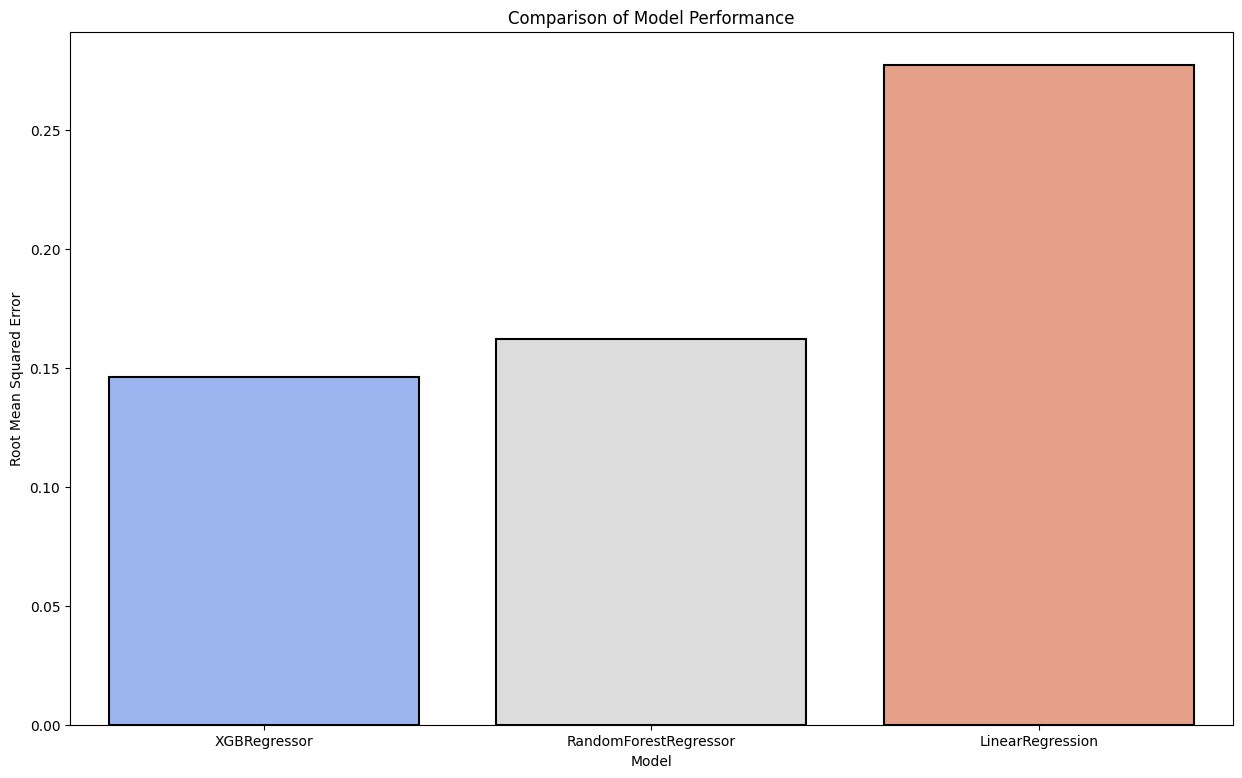

In [41]:

# Visualize the MSE of the 3 models to choose the best model
results = pd.DataFrame({
    'Model': ['LinearRegression', 'RandomForestRegressor', 'XGBRegressor'],
    'RMSE': [rmse_lr, rmse_rf, final_rmse]
})
results.sort_values(by='RMSE', ascending=True, inplace=True)
plt.figure(figsize=(15, 9))
sns.barplot(x='Model', y='RMSE', data=results, palette='coolwarm', edgecolor='black', linewidth=1.5, align="edge")
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error')
plt.title('Comparison of Model Performance')
print(results)
plt.show()

In [ ]:
%pip install lime

# **Model Interpretation** : Random Forest Results

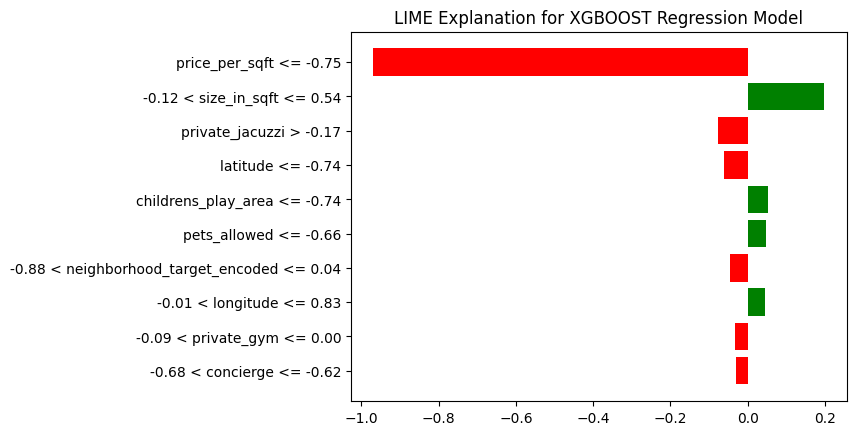

In [42]:
import lime
from lime.lime_tabular import LimeTabularExplainer
from IPython.display import display

#create the Explainer  for XGBOOST regression model
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['price'],
    mode='regression'
)
# Select a sample from the test set to explain
sample_index = 0
sample = X_test.iloc[sample_index].values  # This will be 1D (shape: (n_features,))
# Get the explanation for the sample
explanation = explainer.explain_instance(
    data_row=sample,
    predict_fn=final_model.predict,
    num_features=10
)
# Display the explanation
#explanation.show_in_notebook(show_table=True, show_all=False)
# Display the explanation as a bar chart
explanation.as_pyplot_figure()
plt.title('LIME Explanation for XGBOOST Regression Model')
plt.show()


In [ ]:
%pip install shap

In [ ]:
%pip install --upgrade numpy==2.2.0

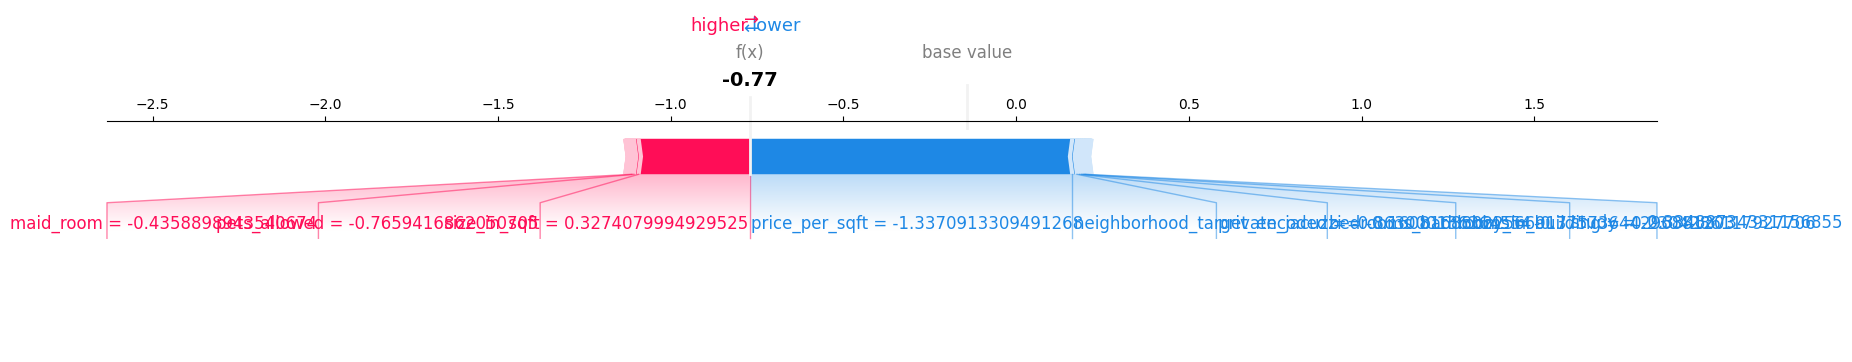

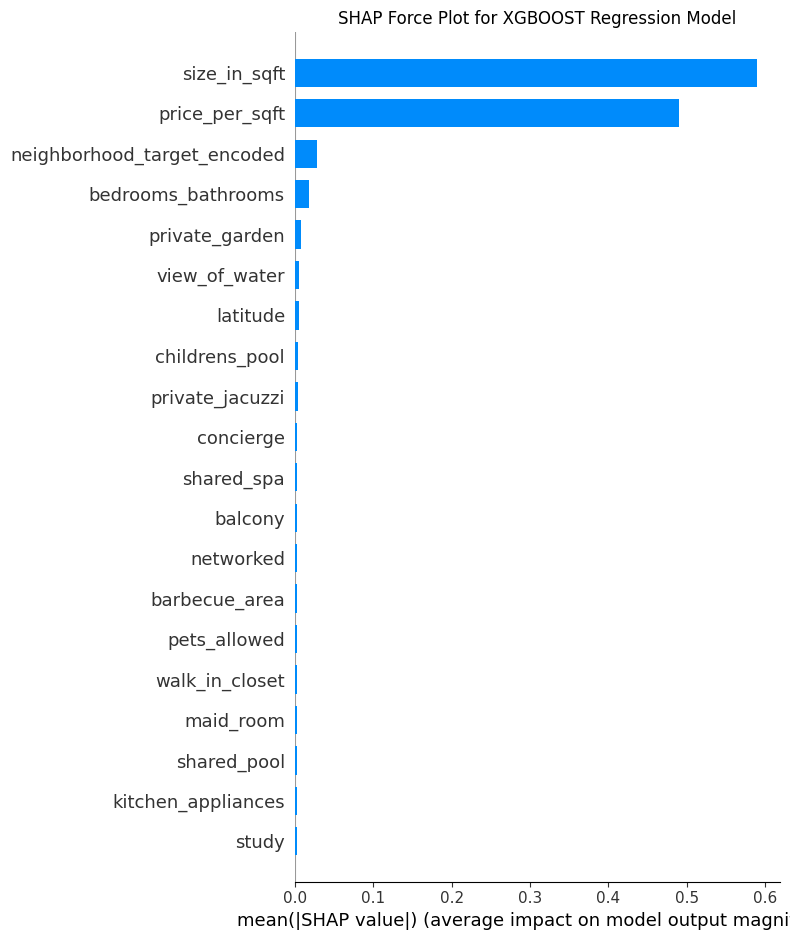

In [ ]:
import shap
# Create a SHAP explainer for the XGBOOST model
explainer = shap.Explainer(final_model, X_train)
# Calculate SHAP values for the test set
shap_values = explainer(X_test)
# Visualize the SHAP values for the first instance in the test set
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0], matplotlib=True)
# Visualize the SHAP summary plot for the entire test set
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [46]:
# Svaving the model
import joblib
joblib.dump(final_model, 'xgboost_model.pkl')

['xgboost_model.pkl']

# Model Deployement

In [ ]:
%pip install "ray[serve]"

In [48]:
import ray
from ray import serve
import numpy as np
import joblib
from fastapi import FastAPI, Request

# Initialize Ray
ray.init(ignore_reinit_error=True)
serve.start(detached=True)

# Load model
model = joblib.load('xgboost_model.pkl')

# FastAPI app
app = FastAPI()

@app.post("/predict")
async def predict(request: Request):
    try:
        data = await request.json()
        features = np.array(data["features"]).reshape(1, -1)
        prediction = model.predict(features)
        return {"prediction": float(prediction[0])}
    except Exception as e:
        import traceback
        traceback.print_exc()
        return {"error": str(e)}

from ray import serve

@serve.deployment
@serve.ingress(app)
class FastAPIWrapper:
    pass

# Deploy FastAPI app using Serve
serve.run(FastAPIWrapper.bind())

2025-06-24 15:18:48,011	INFO worker.py:1747 -- Calling ray.init() again after it has already been called.
INFO 2025-06-24 15:18:48,014 serve 456528 -- Connecting to existing Serve app in namespace "serve". New http options will not be applied.
INFO 2025-06-24 15:18:48,091 serve 456528 -- Connecting to existing Serve app in namespace "serve". New http options will not be applied.
INFO 2025-06-24 15:18:52,124 serve 456528 -- Application 'default' is ready at http://127.0.0.1:8000/.


DeploymentHandle(deployment='FastAPIWrapper')

In [49]:

# To access the deployed model, you can use the following command:
!curl -X POST http://127.0.0.1:8000/predict \
     -H "Content-Type: application/json" \
     -d '{"features": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9]}'


{"prediction":1.3928265571594238}

In [50]:
print(model.n_features_in_)

35
